 build a classification model to predict which patients are at risk for 30-day unplanned readmission utilizing free-text hospital discharge summaries.

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
df_adm = pd.read_csv('ADMISSIONS.csv.gz')

In [3]:
df_adm.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ROW_ID                58976 non-null  int64 
 1   SUBJECT_ID            58976 non-null  int64 
 2   HADM_ID               58976 non-null  int64 
 3   ADMITTIME             58976 non-null  object
 4   DISCHTIME             58976 non-null  object
 5   DEATHTIME             5854 non-null   object
 6   ADMISSION_TYPE        58976 non-null  object
 7   ADMISSION_LOCATION    58976 non-null  object
 8   DISCHARGE_LOCATION    58976 non-null  object
 9   INSURANCE             58976 non-null  object
 10  LANGUAGE              33644 non-null  object
 11  RELIGION              58518 non-null  object
 12  MARITAL_STATUS        48848 non-null  object
 13  ETHNICITY             58976 non-null  object
 14  EDREGTIME             30877 non-null  object
 15  EDOUTTIME             30877 non-null

In [4]:
df_adm.head(100)
#df_adm.shape

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,93,91,121205,2177-04-23 00:08:00,2177-05-10 15:16:00,2177-05-10 15:16:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,JEWISH,MARRIED,WHITE,2177-04-22 21:02:00,2177-04-23 04:03:00,FEVER,1,1
96,94,92,142807,2122-12-13 19:30:00,2123-03-04 13:47:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,SHORT TERM HOSPITAL,Medicaid,NaN,UNOBTAINABLE,NaN,WHITE,NaN,NaN,NEWBORN,0,1
97,95,93,160481,2128-03-17 17:11:00,2128-06-17 15:00:00,NaN,NEWBORN,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1
98,96,94,183686,2176-02-25 16:49:00,2176-02-29 17:45:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,CANT,NOT SPECIFIED,MARRIED,ASIAN,2176-02-25 10:35:00,2176-02-25 18:14:00,SEPSIS,0,1


In [5]:
df_adm2 = df_adm[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE']]

In [6]:
df_adm2.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY


In [7]:
df_adm2.ADMITTIME = pd.to_datetime( df_adm2.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors ='coerce')

df_adm2.DISCHTIME = pd.to_datetime( df_adm2.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors ='coerce')

df_adm2.DEATHTIME = pd.to_datetime( df_adm2.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors ='coerce')

C:\Users\T\AppData\Local\Temp\ipykernel_12976\3163153658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adm2.ADMITTIME = pd.to_datetime( df_adm2.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors ='coerce')
C:\Users\T\AppData\Local\Temp\ipykernel_12976\3163153658.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adm2.DISCHTIME = pd.to_datetime( df_adm2.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors ='coerce')
C:\Users\T\AppData\Local\Temp\ipykernel_12976\3163153658.py:5: SettingWithCopyWarning: 


In [8]:
df_adm2 = df_adm2.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm2 = df_adm2.reset_index(drop = True)

In [9]:
df_adm2.head(100)


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE
...,...,...,...,...,...,...
95,94,183686,2176-02-25 16:49:00,2176-02-29 17:45:00,NaT,EMERGENCY
96,94,140037,2176-09-02 14:22:00,2176-09-25 13:15:00,NaT,EMERGENCY
97,95,160891,2157-12-25 16:28:00,2157-12-27 15:25:00,NaT,EMERGENCY
98,96,170324,2156-03-31 16:11:00,2156-04-29 15:05:00,NaT,EMERGENCY


In [10]:
df_adm2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   SUBJECT_ID      58976 non-null  int64         
 1   HADM_ID         58976 non-null  int64         
 2   ADMITTIME       58976 non-null  datetime64[ns]
 3   DISCHTIME       58976 non-null  datetime64[ns]
 4   DEATHTIME       5854 non-null   datetime64[ns]
 5   ADMISSION_TYPE  58976 non-null  object        
dtypes: datetime64[ns](3), int64(2), object(1)
memory usage: 2.7+ MB


In [11]:
pd.options.display.max_rows
#pd.options.display.max_rows = 60000

60

In [12]:
#df_adm.head(20)
df_adm2['NEXT_ADMITTIME'] = df_adm2.groupby("SUBJECT_ID").ADMITTIME.shift(-1)

#df_adm.head(20)
df_adm2['NEXT_ADMISSION_TYPE'] = df_adm2.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)
df_adm2.head(20)



,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,NaT,NaN
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,NaT,NaN
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN
5,7,118037,2121-05-23 15:05:00,2121-05-27 11:57:00,NaT,NEWBORN,NaT,NaN
6,8,159514,2117-11-20 10:22:00,2117-11-24 14:20:00,NaT,NEWBORN,NaT,NaN
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,NaT,NaN
8,10,184167,2103-06-28 11:36:00,2103-07-06 12:10:00,NaT,NEWBORN,NaT,NaN
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,NaT,NaN


In [13]:
df_adm2[df_adm2['SUBJECT_ID'] == 124]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,172461,2160-06-24 21:25:00,2160-07-15 15:10:00,NaT,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,112906,2161-12-17 03:39:00,2161-12-24 15:35:00,NaT,EMERGENCY,2165-05-21 21:02:00,ELECTIVE
167,124,134369,2165-05-21 21:02:00,2165-06-06 16:00:00,NaT,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,138376,2165-12-31 18:55:00,2166-02-01 06:55:00,2166-02-01 06:55:00,EMERGENCY,NaT,NaN


In [14]:
df_adm2.tail(100)


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
58876,99660,189028,2144-05-17 18:51:00,2144-05-23 14:10:00,NaT,EMERGENCY,NaT,NaN
58877,99661,177077,2160-05-11 23:46:00,2160-05-15 15:06:00,NaT,EMERGENCY,NaT,NaN
58878,99666,128787,2171-07-24 16:38:00,2171-08-07 13:40:00,NaT,EMERGENCY,NaT,NaN
58879,99669,162441,2171-05-06 07:15:00,2171-05-15 14:15:00,NaT,ELECTIVE,NaT,NaN
58880,99674,101645,2105-06-12 19:45:00,2105-06-19 16:45:00,NaT,EMERGENCY,NaT,NaN
...,...,...,...,...,...,...,...,...
58971,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,NaT,EMERGENCY,NaT,NaN
58972,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,NaT,ELECTIVE,NaT,NaN
58973,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,NaT,EMERGENCY,NaT,NaN
58974,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,NaT,ELECTIVE,NaT,NaN


In [15]:
Rows_elective = df_adm2.NEXT_ADMISSION_TYPE == 'ELECTIVE'
#Rows_elective
df_adm2.loc[Rows_elective,'NEXT_ADMITTIME'] = pd.NaT
df_adm2.loc[Rows_elective,'NEXT_ADMISSION_TYPE'] = np.NaN



In [16]:
#sort by subject_ID and admission date
# it is safer to sort right before the fill in case something changed the order above

df_adm2 = df_adm2.sort_values(['SUBJECT_ID','ADMITTIME'])
# back fill (this will take a little while)
df_adm2[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm2.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')


In [17]:
df_adm2.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,NaT,NaN
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,NaT,NaN
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN


In [18]:
df_adm2['DAYS_NEXT_ADMIT'] = (df_adm2.NEXT_ADMITTIME - df_adm2.DISCHTIME).dt.total_seconds()/(24*60*60)

In [19]:
df_adm2.head(20)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,NaT,NaN,NaN
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,NaT,NaN,NaN
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,NaT,NaN,NaN
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,NaT,NaN,NaN
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,NaT,NaN,NaN
5,7,118037,2121-05-23 15:05:00,2121-05-27 11:57:00,NaT,NEWBORN,NaT,NaN,NaN
6,8,159514,2117-11-20 10:22:00,2117-11-24 14:20:00,NaT,NEWBORN,NaT,NaN,NaN
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,NaT,NaN,NaN
8,10,184167,2103-06-28 11:36:00,2103-07-06 12:10:00,NaT,NEWBORN,NaT,NaN,NaN
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaT,EMERGENCY,NaT,NaN,NaN


In [20]:
# Checking the subject id 124 if our previous codes are doing fine or not
df_adm2.loc[df_adm2.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,2165-12-31 18:55:00,EMERGENCY
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


In [21]:
print('Num_readmitted:', (~df_adm2.DAYS_NEXT_ADMIT.isnull()).sum())
print('Total Number:', len(df_adm2))


Num_readmitted: 11399
Total Number: 58976


In [22]:
num_readmitted = (~df_adm2.DAYS_NEXT_ADMIT.isnull()).sum()
total_number = len(df_adm2)

percentage_readmission = (num_readmitted/total_number) * 100
print(percentage_readmission)
# about 19% of patients have been readmitted 



19.328201302224635


In [23]:
num_readmitted_less_30 = (df_adm2.DAYS_NEXT_ADMIT<30.000000).sum()
num_readmitted_less_30


3227


58976 total number of patients 
11399 were readmitted 
3227 patients have been readmitted before in less than 30 days after discharge from the hospital


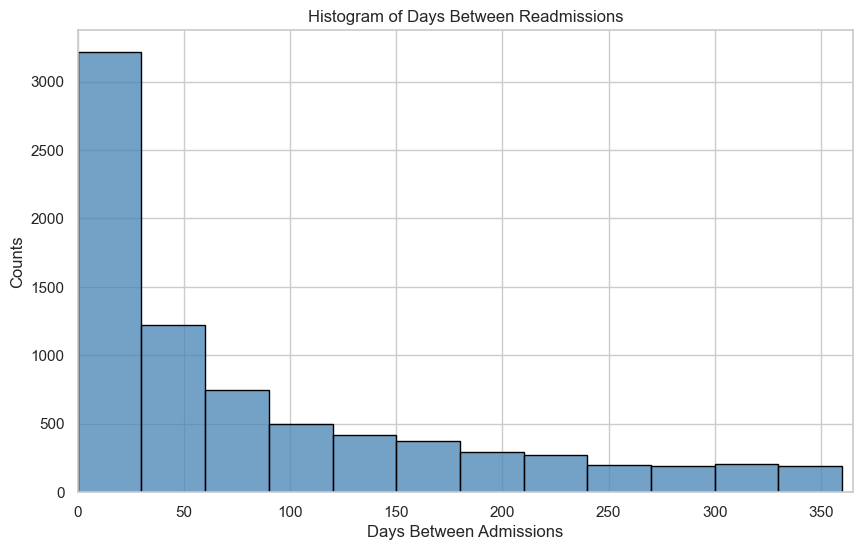

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plot
sns.set(style="whitegrid")

# Create a figure and axis with a specific size
plt.figure(figsize=(10, 6))

# Plot the histogram using Seaborn
sns.histplot(data=df_adm2.loc[~df_adm2.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins=range(0, 365, 30), kde=False, color='steelblue', edgecolor='black')

# Set plot title and labels
plt.title('Histogram of Days Between Readmissions')
plt.xlabel('Days Between Admissions')
plt.ylabel('Counts')

# Set x-axis and y-axis limits
plt.xlim([0, 365])

# Show plot
plt.show()

In [25]:
!pip install seaborn


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
df_notes = pd.read_csv("NOTEEVENTS.csv.gz")


C:\Users\T\AppData\Local\Temp\ipykernel_12976\2246050120.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_notes = pd.read_csv("NOTEEVENTS.csv.gz")


In [27]:
use_cols = ['SUBJECT_ID', 'HADM_ID', 'CATEGORY', 'TEXT']


In [28]:
df_notes = pd.read_csv("NOTEEVENTS.csv.gz",usecols= use_cols, low_memory = False, engine = "c")


In [29]:
print('Number of Notes: {}'.format(len(df_notes)))

Number of Notes: 2083180


In [30]:
df_notes.head()

,SUBJECT_ID,HADM_ID,CATEGORY,TEXT
0,22532,167853.0,Discharge summary,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527.0,Discharge summary,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118.0,Discharge summary,Admission Date: [**2119-5-4**] D...
3,13702,196489.0,Discharge summary,Admission Date: [**2124-7-21**] ...
4,26880,135453.0,Discharge summary,Admission Date: [**2162-3-3**] D...


In [31]:
df_notes.CATEGORY.unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'Nutrition',
       'General', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

In [32]:
df_notes.TEXT.iloc[0]

'Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]\n\n\nService:\nADDENDUM:\n\nRADIOLOGIC STUDIES:  Radiologic studies also included a chest\nCT, which confirmed cavitary lesions in the left lung apex\nconsistent with infectious process/tuberculosis.  This also\nmoderate-sized left pleural effusion.\n\nHEAD CT:  Head CT showed no intracranial hemorrhage or mass\neffect, but old infarction consistent with past medical\nhistory.\n\nABDOMINAL CT:  Abdominal CT showed lesions of\nT10 and sacrum most likely secondary to osteoporosis. These can\nbe followed by repeat imaging as an outpatient.\n\n\n\n                            [**First Name8 (NamePattern2) **] [**First Name4 (NamePattern1) 1775**] [**Last Name (NamePattern1) **], M.D.  [**MD Number(1) 1776**]\n\nDictated By:[**Hospital 1807**]\nMEDQUIST36\n\nD:  [**2151-8-5**]  12:11\nT:  [**2151-8-5**]  12:21\nJOB#:  [**Job Number 1808**]\n'

In [33]:
case_124 = df_notes.loc[df_notes.SUBJECT_ID == 124,['SUBJECT_ID','HADM_ID','CATEGORY','TEXT']]

In [34]:
case_124.CATEGORY.unique()

array(['Discharge summary', 'Echo', 'ECG', 'Physician ', 'Nursing',
       'Respiratory ', 'Rehab Services', 'Nutrition', 'General',
       'Radiology', 'Nursing/other'], dtype=object)

In [35]:
# filter to discharge summary
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']

In [36]:
df_notes_dis_sum.head()

,SUBJECT_ID,HADM_ID,CATEGORY,TEXT
0,22532,167853.0,Discharge summary,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527.0,Discharge summary,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118.0,Discharge summary,Admission Date: [**2119-5-4**] D...
3,13702,196489.0,Discharge summary,Admission Date: [**2124-7-21**] ...
4,26880,135453.0,Discharge summary,Admission Date: [**2162-3-3**] D...


In [37]:
df_notes_dis_sum.duplicated(['HADM_ID']).sum()

6926

assert ..., ""

In [38]:
assert df_notes_dis_sum.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

AssertionError: Multiple discharge summaries per admission


#if df_notes_dis_sum.duplicated(['HADM_ID']).sum() != 0:
    raise AssertionError('Multiple discharge summaries per admission')

In [40]:
df_notes_dis_sum.head()

,SUBJECT_ID,HADM_ID,CATEGORY,TEXT
0,22532,167853.0,Discharge summary,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527.0,Discharge summary,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118.0,Discharge summary,Admission Date: [**2119-5-4**] D...
3,13702,196489.0,Discharge summary,Admission Date: [**2124-7-21**] ...
4,26880,135453.0,Discharge summary,Admission Date: [**2162-3-3**] D...


In [41]:
df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).head()

,SUBJECT_ID,HADM_ID,CATEGORY,TEXT
0,22532,167853.0,Discharge summary,Admission Date: [**2151-7-16**] Dischar...
1,13702,107527.0,Discharge summary,Admission Date: [**2118-6-2**] Discharg...
2,13702,167118.0,Discharge summary,Admission Date: [**2119-5-4**] D...
3,13702,196489.0,Discharge summary,Admission Date: [**2124-7-21**] ...
4,26880,135453.0,Discharge summary,Admission Date: [**2162-3-3**] D...
...,...,...,...,...
60411,93924,135672.0,Discharge summary,"Name: [**Known lastname 18321**],[**Known fir..."
60412,17782,155710.0,Discharge summary,"Name: [**Known lastname 2706**], [**Known fir..."
60413,96333,183951.0,Discharge summary,Name: [**Known lastname 18357**]-[**Known las...
60414,66717,169165.0,Discharge summary,"Name: [**Known lastname **],[**Known firstnam..."


if df_notes_dis_sum.duplicated(['HADM_ID']).sum() != 0:
    raise AssertionError('Multiple discharge summaries per admission')

In [42]:
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
assert df_notes_dis_sum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

subject_id = 13702
subject_data = df_notes_dis_sum_last[df_notes_dis_sum_last['SUBJECT_ID'] == subject_id]
subject_data.TEXT[0]

subject_data

In [43]:
df_adm_notes = pd.merge(df_adm2[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
                        df_notes_dis_sum_last[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')
assert len(df_adm2) == len(df_adm_notes), 'Number of rows increased'

In [44]:
df_adm_notes.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,TEXT
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NaT,NEWBORN,NaT,NaN
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2101-10-20**] Discharg...
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2191-3-16**] Discharge...
3,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NaT,NEWBORN,NaT,NaN
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,NaT,ELECTIVE,NaT,Admission Date: [**2175-5-30**] Dischar...


Check to see if there are alot of notes that are missing text (might be a sign of a problem).

In [45]:
df_adm_notes.TEXT.isnull().sum()

6250

In [46]:
df_adm_notes.TEXT.isnull().sum() / len(df_adm_notes) * 100

10.59753119913185

In [47]:
df_adm_notes.TEXT.str.contains('\n').sum()

52726

In [48]:
df_adm_notes.TEXT.str.contains('\n').sum() / len(df_adm_notes)*100

89.40246880086815

In [49]:
print('Fraction of missing notes:', df_adm_notes.TEXT.isnull().sum() / len(df_adm_notes)*100)
print('Fraction notes with newlines:', df_adm_notes.TEXT.str.contains('\n').sum() / len(df_adm_notes)*100)
print('Fraction notes with carriage returns:', df_adm_notes.TEXT.str.contains('\r').sum() / len(df_adm_notes)*100)

Fraction of missing notes: 10.59753119913185
Fraction notes with newlines: 89.40246880086815
Fraction notes with carriage returns: 0.0


This code calculates the fraction of missing values in the 'TEXT' column for each unique admission type in the `df_adm_notes` DataFrame. It does this by grouping the DataFrame by the 'ADMISSION_TYPE' column, then applying a lambda function to calculate the sum of missing 'TEXT' values for each group. This sum is then divided by the total number of rows for each admission type, resulting in a Series where the index consists of the unique admission types, and the values are the corresponding fractions of missing 'TEXT' values.

In [50]:
df_adm_notes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/df_adm_notes.groupby('ADMISSION_TYPE').size()*100

ADMISSION_TYPE
ELECTIVE      4.866338
EMERGENCY     3.798341
NEWBORN      53.669083
URGENT        4.266467
dtype: float64

In [51]:
df_adm_notes_clean = df_adm_notes.loc[df_adm_notes.ADMISSION_TYPE != 'NEWBORN'].copy()

In [52]:
df_adm_notes_clean.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_NEXT_ADMIT,NEXT_ADMITTIME,ADMISSION_TYPE,DEATHTIME,TEXT
1,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2101-10-20**] Discharg...
2,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2191-3-16**] Discharge...
4,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,NaT,ELECTIVE,NaT,Admission Date: [**2175-5-30**] Dischar...
7,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,NaN,NaT,EMERGENCY,2149-11-14 10:15:00,"Name: [**Known lastname 10050**], [**Known fi..."
9,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaN,NaT,EMERGENCY,NaT,Admission Date: [**2178-4-16**] ...


In [53]:
# Calculate the fraction of missing notes
missing_notes_fraction = df_adm_notes_clean.TEXT.isnull().sum() / len(df_adm_notes_clean)
print('Fraction of missing notes:', "{:.2%}".format(missing_notes_fraction))

# Calculate the fraction of notes with newlines
newlines_fraction = df_adm_notes_clean.TEXT.str.contains('\n').sum() / len(df_adm_notes_clean)
print('Fraction notes with newlines:', "{:.2%}".format(newlines_fraction))

# Calculate the fraction of notes with carriage returns
carriage_returns_fraction = df_adm_notes_clean.TEXT.str.contains('\r').sum() / len(df_adm_notes_clean)
print('Fraction notes with carriage returns:', "{:.2%}".format(carriage_returns_fraction))

Fraction of missing notes: 3.97%
Fraction notes with newlines: 96.03%
Fraction notes with carriage returns: 0.00%


Prepare a label


I like to create a specific column in the dataframe as OUTPUT_LABEL that has exactly what we are trying to predict. Here we want if the patient was re-admitted within 30 days

In [54]:
df_adm_notes_clean['OUTPUT_LABEL'] = (df_adm_notes_clean.DAYS_NEXT_ADMIT < 30).astype('int')

In [55]:
df_adm_notes_clean['OUTPUT_LABEL']

1        0
2        0
4        0
7        0
9        0
        ..
58971    0
58972    0
58973    0
58974    0
58975    0
Name: OUTPUT_LABEL, Length: 51113, dtype: int32

In [56]:
print('Number of positive samples:', (df_adm_notes_clean.OUTPUT_LABEL == 1).sum())
print('Number of negative samples:',  (df_adm_notes_clean.OUTPUT_LABEL == 0).sum())
print('Total samples:', len(df_adm_notes_clean))

num_positive_samples = (df_adm_notes_clean.OUTPUT_LABEL == 1).sum()
num_negative_samples = (df_adm_notes_clean.OUTPUT_LABEL == 0).sum()
total_samples = len(df_adm_notes_clean)

Number of positive samples: 3004
Number of negative samples: 48109
Total samples: 51113


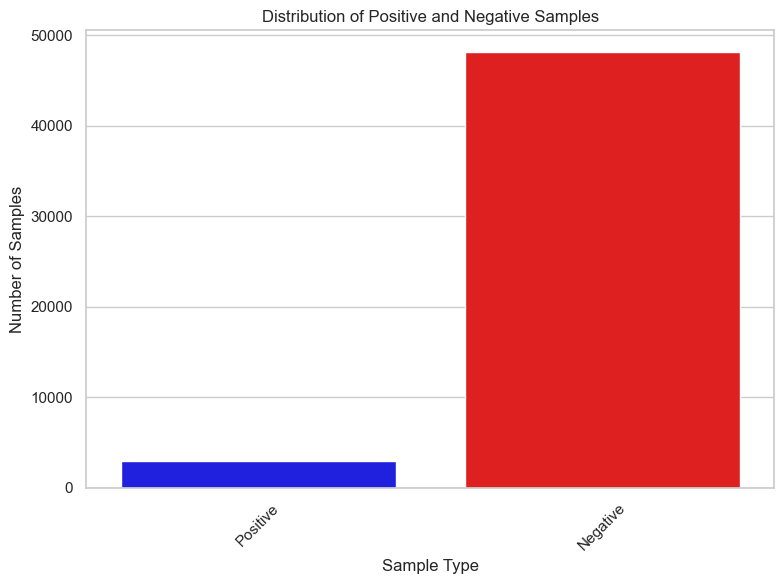

Total samples: 51113


In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=['Positive', 'Negative'], y=[num_positive_samples, num_negative_samples], palette=['blue', 'red'])
plt.xlabel('Sample Type')
plt.ylabel('Number of Samples')
plt.title('Distribution of Positive and Negative Samples')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

# Print total samples
print('Total samples:', total_samples)

In [58]:
# Calculate the percentages
percentage_positive = (num_positive_samples / total_samples) * 100
percentage_negative = (num_negative_samples / total_samples) * 100

# Print the percentages
print('Percentage of Positive Samples:', "{:.2f}%".format(percentage_positive))
print('Percentage of Negative Samples:', "{:.2f}%".format(percentage_negative))
print('Total samples:', total_samples)

Percentage of Positive Samples: 5.88%
Percentage of Negative Samples: 94.12%
Total samples: 51113


## Create training and test dataframes

When we build a predictive model, we want the model to work well on data that the model has never seen. To test for this, we take our data and split it into three datasets: training, validation, and test.

- **Training set:** Used to train the model.
- **Validation set:** Data the model didn't see, but is used to optimize or tune the model.
- **Test set:** Data the model and tuning process never saw, which serves as a true test of generalizability.

The validation and test sets should be as close to the production data as possible. We don't want to make decisions on validation data that are not from the same type of data as the test set. For example, avoid using high-resolution images for the validation set if you expect the production data to consist of amateur photos from your phone.

In [59]:
# # Shuffle the samples
# df_adm_notes_clean = df_adm_notes_clean.sample(frac=1, random_state=42).reset_index(drop=True)

# # Split data into validation, test, and training sets
# frac_validation_test = 0.3 #30% -> validation set
# frac_test = 0.5            # 50% -> testing set

# num_samples = len(df_adm_notes_clean)
# num_validation = int(num_samples * frac_validation_test) # we are going to change num_validatio_test  to num_validation
# num_test = int(num_samples * frac_test)

# df_valid_test = df_adm_notes_clean[:num_validation]
# df_test = df_valid_test.sample(n=num_test, random_state=42)
# df_valid = df_valid_test.drop(df_test.index)
# df_train_all = df_adm_notes_clean[num_validation:]

# # Calculate and print prevalences
# def calculate_prevalence(df):
#     return df.OUTPUT_LABEL.sum() / len(df) * 100

# print(f'Test prevalence (n = {len(df_test)}): {calculate_prevalence(df_test):.2f}%')
# print(f'Valid prevalence (n = {len(df_valid)}): {calculate_prevalence(df_valid):.2f}%')
# print(f'Train all prevalence (n = {len(df_train_all)}): {calculate_prevalence(df_train_all):.2f}%')
# print(f'All samples (n = {num_samples})')

# # Assertion check
# assert num_samples == len(df_test) + len(df_valid) + len(df_train_all), 'Math didn\'t work'


In [64]:
# shuffle the samples
df_adm_notes_clean = df_adm_notes_clean.sample(n = len(df_adm_notes_clean), random_state = 42)
df_adm_notes_clean = df_adm_notes_clean.reset_index(drop = True)

# Save 30% of the data as validation and test data
df_valid_set = df_adm_notes_clean.sample(frac=0.30, random_state=42)

df_test = df_valid_set.sample(frac = 0.5, random_state=42)
df_valid = df_valid_set.drop(df_test.index)

# use the rest of the data as training data
df_train_all = df_adm_notes_clean.drop(df_valid_set.index)

print('Test prevalence(n = %d):'%len(df_test), df_test.OUTPUT_LABEL.sum()/ len(df_test))
print('Valid prevalence(n = %d):'%len(df_valid), df_valid.OUTPUT_LABEL.sum()/ len(df_valid))
print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.OUTPUT_LABEL.sum()/ len(df_train_all))
print('all samples (n = %d)'%len(df_adm_notes_clean))
assert len(df_adm_notes_clean) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

Test prevalence(n = 7667): 0.06051910786487544
Valid prevalence(n = 7667): 0.05738880918220947
Train all prevalence(n = 35779): 0.05869364711143408
all samples (n = 51113)


Since the prevalence is so low, we want to prevent the model from always predicting negative. To do this, we have a few options
- balance the data by sub-sampling the negatives
- balance the data by over-sampling the positives
- create synthetic data (e.g. SMOTE)

In this example, we will sub-sample the negatives

In [70]:
# Under-sampling:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train prevalence (n = {}): {}%'.format(len(df_train), df_train.OUTPUT_LABEL.sum()/ len(df_train)*100))

Train prevalence (n = 4200): 50.0%
